In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_fusion'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 840.73it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
       
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:17<00:00, 15.35img/s]

***
ensemble_fusion Loss: 1.1518020629882812


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.32img/s]

---
ensemble_fusion Validation Dice Loss: 1.2596222162246704
ensemble_fusion Validation Pixel Accuracy: 0.1494140625
ensemble_fusion Validation MIoU: 0.07470707476078847
ensemble_fusion Validation Dice Score: 0.2867572009563446



Epoch 2/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.41img/s]

***
ensemble_fusion Loss: 1.0961267948150635


Epoch 2/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
ensemble_fusion Validation Dice Loss: 1.2795348167419434
ensemble_fusion Validation Pixel Accuracy: 0.18703420538651316
ensemble_fusion Validation MIoU: 0.09975623370876027
ensemble_fusion Validation Dice Score: 0.2955804467201233



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
ensemble_fusion Loss: 1.0132472515106201


Epoch 3/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.24img/s]

---
ensemble_fusion Validation Dice Loss: 1.1172089576721191
ensemble_fusion Validation Pixel Accuracy: 0.5669705574972588
ensemble_fusion Validation MIoU: 0.3732826523566759
ensemble_fusion Validation Dice Score: 0.4408092200756073



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.9511822462081909


Epoch 4/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
ensemble_fusion Validation Dice Loss: 1.0161917209625244
ensemble_fusion Validation Pixel Accuracy: 0.828129015470806
ensemble_fusion Validation MIoU: 0.6296571747062949
ensemble_fusion Validation Dice Score: 0.6689975261688232



Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
ensemble_fusion Loss: 0.8916611671447754


Epoch 5/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
ensemble_fusion Validation Dice Loss: 0.9180557131767273
ensemble_fusion Validation Pixel Accuracy: 0.9041140372293037
ensemble_fusion Validation MIoU: 0.7443523268131728
ensemble_fusion Validation Dice Score: 0.7635286450386047



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
ensemble_fusion Loss: 0.8461953401565552


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.41img/s]

---
ensemble_fusion Validation Dice Loss: 0.8882779479026794
ensemble_fusion Validation Pixel Accuracy: 0.9233331512986568
ensemble_fusion Validation MIoU: 0.7716945656092048
ensemble_fusion Validation Dice Score: 0.7872709035873413



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.8360238671302795


Epoch 7/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
ensemble_fusion Validation Dice Loss: 0.8576593995094299
ensemble_fusion Validation Pixel Accuracy: 0.9342945835046601
ensemble_fusion Validation MIoU: 0.7920240352396383
ensemble_fusion Validation Dice Score: 0.7921169400215149



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
ensemble_fusion Loss: 0.7880884408950806


Epoch 8/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.42img/s]

---
ensemble_fusion Validation Dice Loss: 0.8400314450263977
ensemble_fusion Validation Pixel Accuracy: 0.9318767346833882
ensemble_fusion Validation MIoU: 0.7880975829854222
ensemble_fusion Validation Dice Score: 0.8201944231987



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.7446757555007935


Epoch 9/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.16img/s]

---
ensemble_fusion Validation Dice Loss: 0.8146746158599854
ensemble_fusion Validation Pixel Accuracy: 0.9317332485265899
ensemble_fusion Validation MIoU: 0.7695647957390817
ensemble_fusion Validation Dice Score: 0.7815266847610474



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.7280910015106201


Epoch 10/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.34img/s]

---
ensemble_fusion Validation Dice Loss: 0.8000750541687012
ensemble_fusion Validation Pixel Accuracy: 0.9309025814658717
ensemble_fusion Validation MIoU: 0.7924744127907349
ensemble_fusion Validation Dice Score: 0.8223313689231873



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.7201009392738342


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
ensemble_fusion Validation Dice Loss: 0.7654162645339966
ensemble_fusion Validation Pixel Accuracy: 0.9453250818085253
ensemble_fusion Validation MIoU: 0.8274327043098226
ensemble_fusion Validation Dice Score: 0.852510929107666



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
ensemble_fusion Loss: 0.724968671798706


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.46img/s]

---
ensemble_fusion Validation Dice Loss: 0.7507398724555969
ensemble_fusion Validation Pixel Accuracy: 0.9445990846868146
ensemble_fusion Validation MIoU: 0.8139012671585595
ensemble_fusion Validation Dice Score: 0.8562275171279907



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
ensemble_fusion Loss: 0.7436877489089966


Epoch 13/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]

---
ensemble_fusion Validation Dice Loss: 0.7336894869804382
ensemble_fusion Validation Pixel Accuracy: 0.9501899585389254
ensemble_fusion Validation MIoU: 0.8351477822743628
ensemble_fusion Validation Dice Score: 0.8657078146934509



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
ensemble_fusion Loss: 0.6753016114234924


Epoch 14/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.16img/s]

---
ensemble_fusion Validation Dice Loss: 0.728187084197998
ensemble_fusion Validation Pixel Accuracy: 0.9505144085800439
ensemble_fusion Validation MIoU: 0.8379371102224702
ensemble_fusion Validation Dice Score: 0.8702461123466492



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.20img/s]

***
ensemble_fusion Loss: 0.6662602424621582


Epoch 15/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]

---
ensemble_fusion Validation Dice Loss: 0.7318671345710754
ensemble_fusion Validation Pixel Accuracy: 0.9387520237972862
ensemble_fusion Validation MIoU: 0.8053915772974265
ensemble_fusion Validation Dice Score: 0.8523749709129333



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
ensemble_fusion Loss: 0.6654493808746338


Epoch 16/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.6955698132514954
ensemble_fusion Validation Pixel Accuracy: 0.9494120279947916
ensemble_fusion Validation MIoU: 0.8293593948304423
ensemble_fusion Validation Dice Score: 0.8885015845298767



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.19img/s]

***
ensemble_fusion Loss: 0.6439621448516846


Epoch 17/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.36img/s]

---
ensemble_fusion Validation Dice Loss: 0.6615670919418335
ensemble_fusion Validation Pixel Accuracy: 0.9666745369894463
ensemble_fusion Validation MIoU: 0.8792611672437135
ensemble_fusion Validation Dice Score: 0.8879068493843079



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
ensemble_fusion Loss: 0.6233253479003906


Epoch 18/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
ensemble_fusion Validation Dice Loss: 0.6862893104553223
ensemble_fusion Validation Pixel Accuracy: 0.948867262455455
ensemble_fusion Validation MIoU: 0.8347296720420643
ensemble_fusion Validation Dice Score: 0.8904650807380676



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.6251639127731323


Epoch 19/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
ensemble_fusion Validation Dice Loss: 0.6712579727172852
ensemble_fusion Validation Pixel Accuracy: 0.9521144398471766
ensemble_fusion Validation MIoU: 0.8458620035818585
ensemble_fusion Validation Dice Score: 0.8846881985664368



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
ensemble_fusion Loss: 0.5948193073272705


Epoch 20/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.17img/s]

---
ensemble_fusion Validation Dice Loss: 0.6663027405738831
ensemble_fusion Validation Pixel Accuracy: 0.9527502227247807
ensemble_fusion Validation MIoU: 0.8445871298044137
ensemble_fusion Validation Dice Score: 0.8902344703674316



Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
ensemble_fusion Loss: 0.5838533639907837


Epoch 21/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.33img/s]

---
ensemble_fusion Validation Dice Loss: 0.6474751830101013
ensemble_fusion Validation Pixel Accuracy: 0.9532090571888706
ensemble_fusion Validation MIoU: 0.8446573336165062
ensemble_fusion Validation Dice Score: 0.895063042640686



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.82img/s]

***
ensemble_fusion Loss: 0.5773957371711731


Epoch 22/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.10img/s]

---
ensemble_fusion Validation Dice Loss: 0.6222954988479614
ensemble_fusion Validation Pixel Accuracy: 0.9606384812739858
ensemble_fusion Validation MIoU: 0.8558252585591346
ensemble_fusion Validation Dice Score: 0.8901318907737732



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
ensemble_fusion Loss: 0.5632382035255432


Epoch 23/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.11img/s]

---
ensemble_fusion Validation Dice Loss: 0.6119694709777832
ensemble_fusion Validation Pixel Accuracy: 0.962253771330181
ensemble_fusion Validation MIoU: 0.8674900281115536
ensemble_fusion Validation Dice Score: 0.9015582203865051



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
ensemble_fusion Loss: 0.5643439292907715


Epoch 24/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
ensemble_fusion Validation Dice Loss: 0.6162723302841187
ensemble_fusion Validation Pixel Accuracy: 0.9549999571683114
ensemble_fusion Validation MIoU: 0.847949219548338
ensemble_fusion Validation Dice Score: 0.9011020660400391



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.5463272333145142


Epoch 25/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
ensemble_fusion Validation Dice Loss: 0.592658281326294
ensemble_fusion Validation Pixel Accuracy: 0.9611535323293585
ensemble_fusion Validation MIoU: 0.8669039911581853
ensemble_fusion Validation Dice Score: 0.8781191110610962



Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.5316857099533081


Epoch 26/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.18img/s]

---
ensemble_fusion Validation Dice Loss: 0.5747883915901184
ensemble_fusion Validation Pixel Accuracy: 0.9669880114103618
ensemble_fusion Validation MIoU: 0.8823943069542848
ensemble_fusion Validation Dice Score: 0.8937113881111145



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.79img/s]

***
ensemble_fusion Loss: 0.5165488719940186


Epoch 27/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]

---
ensemble_fusion Validation Dice Loss: 0.5722333192825317
ensemble_fusion Validation Pixel Accuracy: 0.9687604402240954
ensemble_fusion Validation MIoU: 0.890247591637577
ensemble_fusion Validation Dice Score: 0.9133175015449524



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.5247969627380371


Epoch 28/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.5845850706100464
ensemble_fusion Validation Pixel Accuracy: 0.9635001734683388
ensemble_fusion Validation MIoU: 0.87563267618983
ensemble_fusion Validation Dice Score: 0.9133026003837585



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.14img/s]

***
ensemble_fusion Loss: 0.538847804069519


Epoch 29/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.37img/s]

---
ensemble_fusion Validation Dice Loss: 0.5802299976348877
ensemble_fusion Validation Pixel Accuracy: 0.9646991930509868
ensemble_fusion Validation MIoU: 0.8786215475695219
ensemble_fusion Validation Dice Score: 0.9148815274238586



Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.20img/s]

***
ensemble_fusion Loss: 0.5122941732406616


Epoch 30/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
ensemble_fusion Validation Dice Loss: 0.575234055519104
ensemble_fusion Validation Pixel Accuracy: 0.9657914011101973
ensemble_fusion Validation MIoU: 0.882237501132402
ensemble_fusion Validation Dice Score: 0.9146329164505005



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.51026451587677


Epoch 31/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
ensemble_fusion Validation Dice Loss: 0.5700019598007202
ensemble_fusion Validation Pixel Accuracy: 0.9667660897238213
ensemble_fusion Validation MIoU: 0.8838214601249283
ensemble_fusion Validation Dice Score: 0.9163388609886169



Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.5187770128250122


Epoch 32/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.30img/s]

---
ensemble_fusion Validation Dice Loss: 0.5705430507659912
ensemble_fusion Validation Pixel Accuracy: 0.9667867024739584
ensemble_fusion Validation MIoU: 0.884678947635112
ensemble_fusion Validation Dice Score: 0.9182756543159485



Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.14img/s]

***
ensemble_fusion Loss: 0.4946587085723877


Epoch 33/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.29img/s]

---
ensemble_fusion Validation Dice Loss: 0.5695227384567261
ensemble_fusion Validation Pixel Accuracy: 0.9667698374965734
ensemble_fusion Validation MIoU: 0.8834127224222883
ensemble_fusion Validation Dice Score: 0.9200607538223267



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
ensemble_fusion Loss: 0.5087284445762634


Epoch 34/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
ensemble_fusion Validation Dice Loss: 0.5731559991836548
ensemble_fusion Validation Pixel Accuracy: 0.964856599506579
ensemble_fusion Validation MIoU: 0.8792492103141571
ensemble_fusion Validation Dice Score: 0.9149674773216248



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
ensemble_fusion Loss: 0.5115175843238831


Epoch 35/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.5721943378448486
ensemble_fusion Validation Pixel Accuracy: 0.9650027626439145
ensemble_fusion Validation MIoU: 0.8801563198005098
ensemble_fusion Validation Dice Score: 0.9166240692138672



Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.4974954128265381


Epoch 36/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.26img/s]

---
ensemble_fusion Validation Dice Loss: 0.5670180320739746
ensemble_fusion Validation Pixel Accuracy: 0.9661543996710527
ensemble_fusion Validation MIoU: 0.8820981164958717
ensemble_fusion Validation Dice Score: 0.9193668365478516



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.05img/s]

***
ensemble_fusion Loss: 0.5046709775924683


Epoch 37/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.40img/s]

---
ensemble_fusion Validation Dice Loss: 0.568793535232544
ensemble_fusion Validation Pixel Accuracy: 0.9657030607524671
ensemble_fusion Validation MIoU: 0.8813815917718972
ensemble_fusion Validation Dice Score: 0.9185353517532349



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.12img/s]

***
ensemble_fusion Loss: 0.5012867450714111


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]

---
ensemble_fusion Validation Dice Loss: 0.5695706605911255
ensemble_fusion Validation Pixel Accuracy: 0.9654093959875274
ensemble_fusion Validation MIoU: 0.8806287523638757
ensemble_fusion Validation Dice Score: 0.9185299277305603



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
ensemble_fusion Loss: 0.5069673657417297


Epoch 39/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]

---
ensemble_fusion Validation Dice Loss: 0.5713762044906616
ensemble_fusion Validation Pixel Accuracy: 0.965039704975329
ensemble_fusion Validation MIoU: 0.879971571046273
ensemble_fusion Validation Dice Score: 0.9178555607795715



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
ensemble_fusion Loss: 0.5030118227005005


Epoch 40/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.17img/s]

---
ensemble_fusion Validation Dice Loss: 0.5673599243164062
ensemble_fusion Validation Pixel Accuracy: 0.9654401812637061
ensemble_fusion Validation MIoU: 0.8810048441045812
ensemble_fusion Validation Dice Score: 0.9167707562446594



Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.05img/s]

***
ensemble_fusion Loss: 0.5020628571510315


Epoch 41/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.37img/s]

---
ensemble_fusion Validation Dice Loss: 0.5670937299728394
ensemble_fusion Validation Pixel Accuracy: 0.9662213241844847
ensemble_fusion Validation MIoU: 0.8830092683110402
ensemble_fusion Validation Dice Score: 0.9187355041503906



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.13img/s]

***
ensemble_fusion Loss: 0.502059817314148


Epoch 42/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.43img/s]

---
ensemble_fusion Validation Dice Loss: 0.569307804107666
ensemble_fusion Validation Pixel Accuracy: 0.9657972904673794
ensemble_fusion Validation MIoU: 0.8818963129754844
ensemble_fusion Validation Dice Score: 0.9183748364448547



Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
ensemble_fusion Loss: 0.5087811946868896


Epoch 43/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.5703747868537903
ensemble_fusion Validation Pixel Accuracy: 0.9656326561643366
ensemble_fusion Validation MIoU: 0.8814496577687063
ensemble_fusion Validation Dice Score: 0.919121265411377



Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.5137844085693359


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.38img/s]

---
ensemble_fusion Validation Dice Loss: 0.5679962038993835
ensemble_fusion Validation Pixel Accuracy: 0.966192412794682
ensemble_fusion Validation MIoU: 0.8825952222881612
ensemble_fusion Validation Dice Score: 0.9198269248008728



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.5193268060684204


Epoch 45/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.28img/s]

---
ensemble_fusion Validation Dice Loss: 0.570009708404541
ensemble_fusion Validation Pixel Accuracy: 0.9655054995888158
ensemble_fusion Validation MIoU: 0.8808967135473593
ensemble_fusion Validation Dice Score: 0.9190463423728943



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.5056194067001343


Epoch 46/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.22img/s]

---
ensemble_fusion Validation Dice Loss: 0.5685089826583862
ensemble_fusion Validation Pixel Accuracy: 0.9658387836657072
ensemble_fusion Validation MIoU: 0.881431791310956
ensemble_fusion Validation Dice Score: 0.9195866584777832



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.96img/s]

***
ensemble_fusion Loss: 0.5136204957962036


Epoch 47/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.44img/s]

---
ensemble_fusion Validation Dice Loss: 0.5686009526252747
ensemble_fusion Validation Pixel Accuracy: 0.9651679323430646
ensemble_fusion Validation MIoU: 0.8803917809722221
ensemble_fusion Validation Dice Score: 0.917503833770752



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.4990052580833435


Epoch 48/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]

---
ensemble_fusion Validation Dice Loss: 0.5658184885978699
ensemble_fusion Validation Pixel Accuracy: 0.9664753696374726
ensemble_fusion Validation MIoU: 0.8831819501712509
ensemble_fusion Validation Dice Score: 0.9198158383369446



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
ensemble_fusion Loss: 0.5034047365188599


Epoch 49/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.33img/s]

---
ensemble_fusion Validation Dice Loss: 0.5655942559242249
ensemble_fusion Validation Pixel Accuracy: 0.9666723954050165
ensemble_fusion Validation MIoU: 0.8839959166989739
ensemble_fusion Validation Dice Score: 0.9198288917541504



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
ensemble_fusion Loss: 0.5111871957778931


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.28img/s]

---
ensemble_fusion Validation Dice Loss: 0.5662734508514404
ensemble_fusion Validation Pixel Accuracy: 0.9663950602213541
ensemble_fusion Validation MIoU: 0.8833670871696413
ensemble_fusion Validation Dice Score: 0.9187063574790955


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

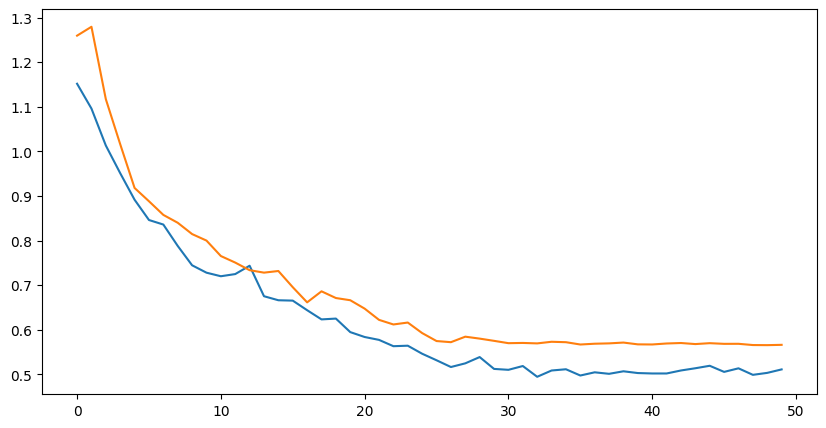

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

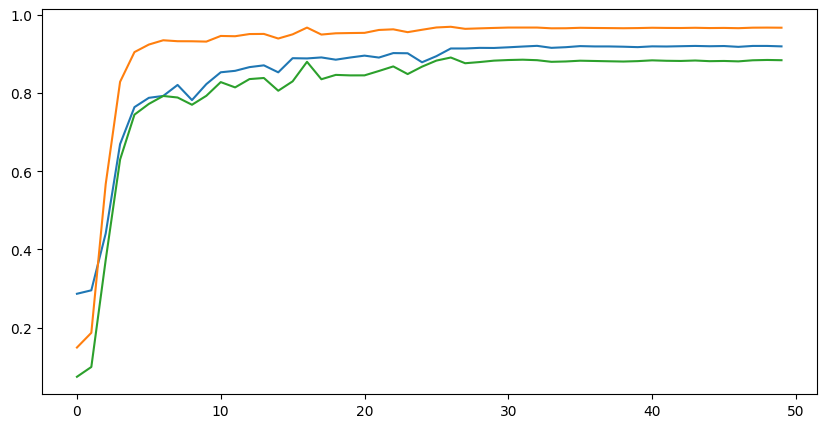

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)